In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math
from keras.applications import VGG16, vgg16
from keras import backend as K
import matplotlib.pyplot as plt
%matplotlib inline

Using Theano backend.
Using gpu device 2: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 4007)


In [7]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (0, 1, 2)))
    gram = K.dot(features, K.transpose(features))
    return gram

# the "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image

def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    sLoss = K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return sLoss

def content_loss(base, combination):
    return K.sum(K.square(combination - base))


def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, 1:, :img_ncols - 1])
    b = K.square(x[:, :, :img_nrows - 1, :img_ncols - 1] - x[:, :, :img_nrows - 1, 1:])
    return K.sum(K.pow(a + b, 1.25))

In [8]:
total_variation_weight = 1.0
style_weight = 100.0
content_weight = 0.025

img_nrows = 400
img_ncols = 400

In [9]:
# style_loss
def get_loss(y_true, y_pred):
    loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    print "loss", K.shape(loss), loss
    return style_weight*loss

def c_loss(y_true, y_pred):
    loss = content_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    print "c_loss", K.shape(loss), loss
#     loss += total_variation_loss(y_pred)
    return content_weight*loss

def var_loss(y_true, y_pred):
    loss = total_variation_weight*total_variation_loss(y_pred)
    return loss

In [10]:
# Combine generative layer with VGG layer
inputs = Input(shape=(3, None,None))

vggTmp = vgg16.VGG16(input_tensor = inputs, weights='imagenet', include_top=False)
for layer in vggTmp.layers:
    layer.trainable=False

x1 = vggTmp.layers[12].output
# 512, 28, 28

# Joining layer
x = Convolution2D(64, 3, 3, border_mode = 'same', activation = 'tanh', init = 'glorot_normal')(x1)
x = MaxPooling2D(pool_size = (2, 2))(x)

x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh', init = 'glorot_normal')(x)

x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh', init = 'glorot_normal')(x)

x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh', init = 'glorot_normal')(x)


x = UpSampling2D(size = (2, 2))(x) # 28, 28 -> 224, 224
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid', init = 'glorot_normal')(x)


generative_model = Model(input = inputs, output = out)

# VGG model
vgg_model = VGG16(weights = 'imagenet', include_top = False)
for layer in vgg_model.layers:
    layer.trainable = False

fl = ['block1_conv1', 'block2_conv1','block3_conv1', 'block4_conv1', 'block5_conv1', 'block4_conv2']
ot = dict([(layer.name, layer.output) for layer in vgg_model.layers])
outputs = [vgg_model.input, ot[fl[5]], ot[fl[0]], ot[fl[1]], ot[fl[2]], ot[fl[3]], ot[fl[4]]]
# Discriminative model
disc_model = Model(input = vgg_model.input, output = outputs)
vgg_out = disc_model(out)

# Final model
fin_model = Model(input = inputs, output = vgg_out)

In [11]:
fin_model.compile(loss = [var_loss, c_loss, get_loss, get_loss, get_loss, get_loss, get_loss], optimizer = 'adam')

c_loss Shape.0 Sum{acc_dtype=float64}.0
loss Shape.0 Elemwise{true_div,no_inplace}.0
loss Shape.0 Elemwise{true_div,no_inplace}.0
loss Shape.0 Elemwise{true_div,no_inplace}.0
loss Shape.0 Elemwise{true_div,no_inplace}.0
loss Shape.0 Elemwise{true_div,no_inplace}.0


In [12]:
def get_style_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    inp = np.reshape(inp, (1, 3, 400, 400))
    styleY = disc_model.predict([inp/256.0])
    return styleY

def get_origin_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    inp = np.reshape(inp, (1, 3, 400, 400))
    contentY = disc_model.predict([inp/256.0])
    return contentY

def get_train_features(filename):
    jpgfile = Image.open(filename)
    inp = np.array(jpgfile.getdata())
    inp = inp.swapaxes(0, 1)
    trainX = np.reshape(inp, (1, 3, 400, 400))
#     trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))
    trainX3 = trainX/256.0
    return trainX3

In [13]:
styleY = get_style_features('starry400.jpg') 
contentY = get_origin_features('ucsd400.jpg')
trainX3 = get_train_features('ucsd400.jpg')
styleY[1] = contentY[1]

In [ ]:
import time
start = time.time()
hist = fin_model.fit(trainX3, styleY, nb_epoch = 300, verbose = 0)
end = time.time()
print "Time taken", end-start

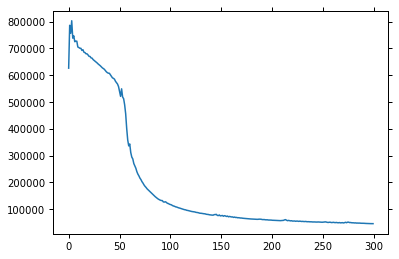

In [156]:
plt.plot(xrange(0, 300), hist.history['loss'])
plt.savefig('plot_vgg-gnst_tanh_2.jpg')

In [158]:
import scipy.misc
scipy.misc.imsave('img_vgg-gnst_tanh_2.jpg', img)

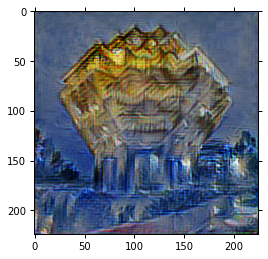

In [157]:
img = generative_model.predict(trainX3)
img = img[0]
img = img.swapaxes(0, 2).swapaxes(0, 1)
plt.imshow(img)
# plt.savefig('img_vgg-gnst_tanh_1.jpg')

(224, 224, 3)


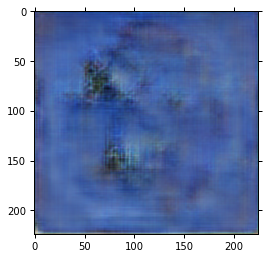

In [96]:
img = generative_model.predict(get_train_features('sun.jpg'))
img = img[0]
imgB = img.swapaxes(0, 2).swapaxes(0, 1)
print imgB.shape
plt.imshow(imgB)
plt.show()

In [ ]:
# More layers - 37.43s
# Less layers - 32